In [ ]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
from datetime import datetime
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Input, concatenate
from tensorflow.keras.layers import Layer, BatchNormalization, MaxPooling2D, Concatenate, Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from tensorflow.keras.regularizers import l2
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
import math
from scipy.spatial.distance import euclidean as dist
import json
from tensorflow.python.client import device_lib
import matplotlib.gridspec as gridspec
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf
import matplotlib.pyplot as plt, numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.utils import plot_model
from sklearn.decomposition import PCA

### Load data from Kaggle





In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d alessiocorrado99/animals10


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 583M/586M [00:29<00:00, 21.1MB/s]
100% 586M/586M [00:29<00:00, 20.6MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('animals10.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/animals10')


### Data filtering

In [ ]:
import os
import shutil

classes_to_keep = ['cane', 'gatto', 'ragno', 'gallina']

original_dataset_dir = '/content/animals10/raw-img'

filtered_dataset_dir = '/content/filtered_animals10'

os.makedirs(filtered_dataset_dir, exist_ok=True)

for class_name in classes_to_keep:
    class_dir = os.path.join(filtered_dataset_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    class_images_dir = os.path.join(original_dataset_dir, class_name)

    for image_filename in os.listdir(class_images_dir):
        src = os.path.join(class_images_dir, image_filename)
        dst = os.path.join(class_dir, image_filename)
        shutil.copyfile(src, dst)

print("Filtered dataset created successfully.")


Filtered dataset created successfully.


### Loading Images from Folder and Extracting Labels

In [ ]:
# import os
# import numpy as np
# import cv2

# def load_images_from_folder(folder_path):
#     images = []
#     labels = []
#     class_folders = sorted(os.listdir(folder_path))
#     for class_idx, class_folder in enumerate(class_folders):
#         class_path = os.path.join(folder_path, class_folder)
#         if os.path.isdir(class_path):
#             for filename in os.listdir(class_path):
#                 img_path = os.path.join(class_path, filename)
#                 if img_path.endswith(".jpg") or img_path.endswith(".png")or img_path.endswith(".jpeg"):
#                     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#                     if img is not None:
#                         img = cv2.resize(img, (100, 100))
#                         images.append(img)
#                         labels.append(class_folder)
#     return np.array(images), np.array(labels)

# X, Y = load_images_from_folder(filtered_dataset_dir)

# print("Shape of X:", X.shape)
# print("Shape of Y:", Y.shape)


Shape of X: (14450, 100, 100)
Shape of Y: (14450,)


In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

def augment_image(image):

    if random.random( )> 0.5:
        image = cv2.flip(image, 1)  # Horizontal flip

    if random.random() > 0.5:
        beta = random.randint(-20, 20)  # Brightness offset
        image = cv2.convertScaleAbs(image, beta=beta)

    return image


In [ ]:
import os
import numpy as np
import cv2
import random
images = []
labels = []
def load_images_from_folder(folder_path):

    class_folders = sorted(os.listdir(folder_path))
    for class_idx, class_folder in enumerate(class_folders):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                if img_path.endswith(".jpg") or img_path.endswith(".png") or img_path.endswith(".jpeg"):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (70, 70))
                        # Append original image
                        images.append(img)
                        labels.append(class_folder)

                        # Augment the image and append it
                        # augmented_img = augment_image(img)
                        # images.append(augmented_img)
                        # labels.append(class_folder)
    return np.array(images), np.array(labels)


# Example use
filtered_dataset_dir = '/content/filtered_animals10' # Replace with your dataset path
X, Y = load_images_from_folder(filtered_dataset_dir)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (14450, 70, 70)
Shape of Y: (14450,)


In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

def augment_image(image):

    if random.random( )> 0.5:
        image = cv2.flip(image, 1)  # Horizontal flip

    if random.random() > 0.5:
        beta = random.randint(-10, 10)  # Brightness offset
        image = cv2.convertScaleAbs(image, beta=beta)

    return image


In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=25):
    gaussian_noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, gaussian_noise)
    return noisy_image

# Function to augment the image
def augment_image1(image):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)  # Horizontal flip

    if random.random() > 0.5:
        beta = random.randint(-20, 20)  # Brightness offset
        image = cv2.convertScaleAbs(image, beta=beta)

    if 1 > 0.5:
        image = add_gaussian_noise(image, mean=0, std=0.2)  # Set std to 0 to remove noise

    return image




In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=25):
    gaussian_noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, gaussian_noise)
    return noisy_image

# Function to augment the image
def augment_image2(image):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)  # Horizontal flip

    if random.random() > 0.5:
        beta = random.randint(-3, 3)  # Brightness offset
        image = cv2.convertScaleAbs(image, beta=beta)

    if random.random() > 0.5:
        image = add_gaussian_noise(image, mean=0, std=0.2)  # Set std to 0 to remove noise

    return image




In [ ]:
import os
import numpy as np
import cv2
import random
images1 =[]
labels1=[]
def load_images_from_folder(folder_path):
    class_folders = sorted(os.listdir(folder_path))
    class_of_interest = 1  # We're interested in class 2

    for class_idx, class_folder in enumerate(class_folders):
        class_path = os.path.join(folder_path, class_folder)

        if os.path.isdir(class_path):
            print(f"Processing class: {class_folder}")

            # Only process class 2
            if class_idx == class_of_interest:
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    if img_path.endswith((".jpg", ".png", ".jpeg")):
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, (70, 70))

                            # Augment the image and append it
                            augmented_img = augment_image(img)
                            images1.append(augmented_img)
                            labels1.append(class_folder)
                            # augmented_img1 = augment_image1(img)
                            # images1.append(augmented_img1)
                            # labels1.append(class_folder)
                            # augmented_img2 = augment_image2(img)
                            # images1.append(augmented_img2)
                            # labels1.append(class_folder)
    return np.array(images1), np.array(labels1)

# Example use
filtered_dataset_dir = '/content/filtered_animals10'  # Replace with your dataset path
X1, Y1 = load_images_from_folder(filtered_dataset_dir)

print("Shape of X1:", X1.shape)
print("Shape of Y1:", Y1.shape)

Processing class: cane
Processing class: gallina
Processing class: gatto
Processing class: ragno
Shape of X1: (3098, 70, 70)
Shape of Y1: (3098,)


In [ ]:
X = np.concatenate(( X, X1))
print("Concatenated shape (vertically):", X.shape)  # (200, 100, 3)


Concatenated shape (vertically): (20884, 70, 70)


In [ ]:
Y =  np.concatenate(( Y, Y1))


### Label Mapping for Image Classes

In [ ]:
label_mapping = {'cane': 0, 'gallina': 1, 'gatto': 2, 'ragno': 3}

Y= np.array([label_mapping[label] if label in label_mapping else -1 for label in Y])

In [ ]:
Y.shape

(32236,)

In [ ]:
from collections import Counter

label_counts = Counter(Y)

for class_label, count in label_counts.items():
    print(f"Class {class_label} has {count} data points.")

Class 0 has 4863 data points.
Class 1 has 6196 data points.
Class 2 has 5004 data points.
Class 3 has 4821 data points.


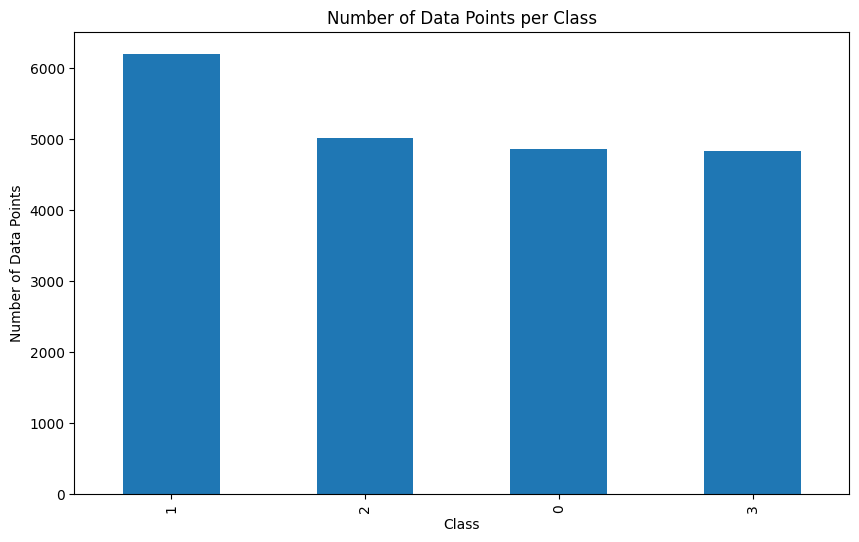

In [ ]:
import pandas as pd

Y_series = pd.Series(Y)
class_counts = Y_series.value_counts()

# Plotting the data
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Number of Data Points per Class')
plt.xlabel('Class')
plt.ylabel('Number of Data Points')
plt.show()


from sklearn.model_selection import train_test_split  


In [ ]:
# Splitting the data into train, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42 ,stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (14618, 70, 70)
Shape of Y_train: (14618,)
Shape of X_val: (4386, 70, 70)
Shape of Y_val: (4386,)
Shape of X_test: (1880, 70, 70)
Shape of Y_test: (1880,)


In [ ]:
from collections import Counter

label_counts = Counter(Y_train)

for class_label, count in label_counts.items():
    print(f"Class {class_label} has {count} data points.")

Class 2 has 3503 data points.
Class 0 has 3404 data points.
Class 1 has 4337 data points.
Class 3 has 3374 data points.


### working on Training Data


### Selecting  2000 Data Samples from Each Class


In [ ]:
import numpy as np

def select_data(X, Y, num_samples_per_class=2500):
    class_indices = {}

    for i, label in enumerate(Y):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)

    selected_indices = []

    for label, indices in class_indices.items():
        if len(indices) >= num_samples_per_class:
            selected_indices.extend(np.random.choice(indices, size=num_samples_per_class, replace=False))
        else:
            selected_indices.extend(np.random.choice(indices, size=num_samples_per_class, replace=True))

    X_selected = X[selected_indices]
    Y_selected = Y[selected_indices]

    return X_selected, Y_selected

x_train, y_train = select_data(X, Y, num_samples_per_class=2500)



In [ ]:
from collections import Counter

label_counts = Counter(y_train)

for class_label, count in label_counts.items():
    print(f"Class {class_label} has {count} data points.")

Class 0 has 2500 data points.
Class 1 has 2500 data points.
Class 2 has 2500 data points.
Class 3 has 2500 data points.


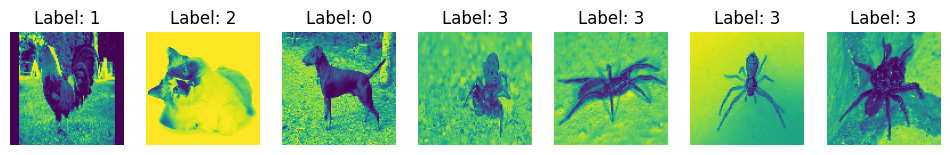

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title('Label: {}'.format(labels[i]))
        ax.axis('off')

random_indices = np.random.choice(len(X), size=10, replace=False)

selected_images = [X[i] for i in random_indices]
selected_labels = [Y[i] for i in random_indices]

plot_images(selected_images, selected_labels, rows=1, cols=7)
plt.show()


### for test

In [ ]:
import numpy as np

def select_data(X, Y, num_samples_per_class=1000):
    class_indices = {}

    for i, label in enumerate(Y):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)

    selected_indices = []

    for label, indices in class_indices.items():
        if len(indices) >= num_samples_per_class:
            selected_indices.extend(np.random.choice(indices, size=num_samples_per_class, replace=False))
        else:
            selected_indices.extend(np.random.choice(indices, size=num_samples_per_class, replace=True))

    X_selected = X[selected_indices]
    Y_selected = Y[selected_indices]

    return X_selected, Y_selected

x_test, y_test= select_data(X, Y, num_samples_per_class=1500)
import numpy as np

indices = np.random.permutation(len(x_test))

x_test= x_test[indices]
y_test = y_test[indices]


### Randomly Shuffling Training Data and Labels

In [ ]:

Y_train[:100]

array([0, 3, 0, 1, 0, 0, 3, 0, 3, 3, 3, 1, 2, 1, 3, 0, 0, 3, 2, 0, 0, 1,
       2, 3, 0, 2, 3, 2, 3, 0, 2, 3, 3, 0, 2, 1, 0, 0, 3, 2, 1, 2, 0, 3,
       0, 3, 1, 0, 3, 3, 3, 0, 0, 2, 0, 0, 3, 0, 2, 2, 3, 0, 2, 3, 0, 0,
       3, 2, 3, 3, 3, 0, 0, 2, 3, 1, 3, 3, 0, 0, 3, 1, 0, 0, 3, 3, 3, 3,
       3, 0, 1, 2, 3, 3, 0, 0, 3, 3, 0, 1])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
        ax.axis('off')

random_indices = np.random.choice(len(x_train), size=10, replace=False)

selected_images = [x_train[i] for i in random_indices]
selected_labels = [y_train[i] for i in random_indices]

plot_images(selected_images, selected_labels, rows=1, cols=7)
plt.show()


NameError: name 'x_train' is not defined

In [ ]:

import numpy as np

indices = np.random.permutation(len(x_train))

x_train= x_train[indices]
y_train = y_train[indices]


In [ ]:
y_train[:100]

array([3, 0, 3, 2, 3, 3, 1, 3, 1, 1, 0, 3, 3, 0, 2, 3, 2, 1, 0, 1, 1, 2,
       1, 1, 1, 2, 0, 2, 3, 0, 3, 3, 0, 1, 0, 2, 0, 2, 0, 3, 3, 2, 1, 1,
       1, 3, 0, 2, 1, 2, 3, 3, 2, 0, 1, 0, 3, 3, 0, 2, 3, 0, 1, 0, 0, 2,
       2, 0, 2, 1, 1, 2, 3, 2, 2, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0, 2, 2, 2,
       3, 3, 3, 1, 2, 3, 3, 0, 3, 1, 0, 0])

In [ ]:
print("x_train shape is", x_train.shape)
print("y_train sgape is ",y_train.shape)


NameError: name 'x_train' is not defined

### Visualizing Randomly Selected Images from Training Data

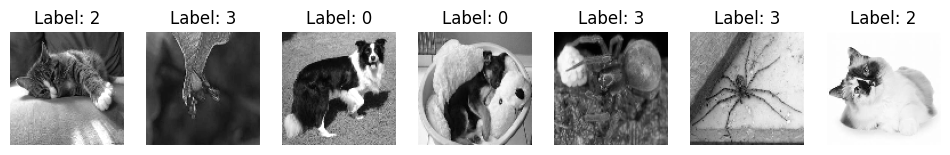

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
        ax.axis('off')

random_indices = np.random.choice(len(X_train), size=10, replace=False)

selected_images = [X_train[i] for i in random_indices]
selected_labels = [Y_train[i] for i in random_indices]

plot_images(selected_images, selected_labels, rows=1, cols=7)
plt.show()


### working on validation Data

### Selecting 1500 Data Samples from Each Class

In [ ]:

def select_data(X, Y, num_samples_per_class=1500):
    class_indices = {}

    for i, label in enumerate(Y):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)

    selected_indices = []

    for label, indices in class_indices.items():
        if len(indices) >= num_samples_per_class:
            selected_indices.extend(np.random.choice(indices, size=num_samples_per_class, replace=False))
        else:
            selected_indices.extend(np.random.choice(indices, size=num_samples_per_class, replace=True))

    X_selected = X[selected_indices]
    Y_selected = Y[selected_indices]

    return X_selected, Y_selected

x_val, y_val = select_data(X, Y, num_samples_per_class=1500)



In [ ]:
import numpy as np

class_counts = np.bincount(y_val)

for label, count in enumerate(class_counts):
    print(f"Label {label}: {count} samples")


Label 0: 1500 samples
Label 1: 1500 samples
Label 2: 1500 samples
Label 3: 1500 samples


### Random Data Selection for Validation

In [ ]:
y_val[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
import numpy as np

indices = np.random.permutation(len(y_val))

x_val= x_val[indices]
y_val = y_val[indices]


In [ ]:
y_val[:100]

array([0, 2, 0, 2, 0, 1, 1, 0, 2, 3, 1, 2, 0, 2, 2, 2, 1, 3, 3, 3, 2, 1,
       0, 1, 1, 2, 1, 0, 3, 3, 1, 0, 3, 3, 2, 0, 0, 2, 0, 3, 2, 2, 0, 3,
       2, 1, 3, 0, 2, 2, 3, 0, 2, 3, 1, 2, 2, 2, 3, 3, 0, 2, 2, 1, 1, 1,
       2, 0, 3, 2, 3, 0, 1, 2, 3, 2, 1, 1, 2, 2, 2, 3, 3, 1, 0, 1, 0, 0,
       3, 2, 1, 3, 0, 1, 1, 3, 2, 3, 0, 2])

In [ ]:

print("x_val shape is", x_val.shape)
print("y_val sgape is ",y_val.shape)


x_val shape is (6000, 100, 100)
y_val sgape is  (6000,)


In [ ]:
# import matplotlib.pyplot as plt

# # Plot the first 8 samples
# plt.figure(figsize=(12, 6))
# for i in range(8):
#     plt.subplot(2, 4, i + 1)
#     plt.imshow(x_train[i], cmap='gray')
#     plt.title(f"Sample {i + 1}")
#     plt.axis('off')
# plt.tight_layout()
# plt.show()


### Normalization of Input Data

In [ ]:
X_train = X_train.astype('float16')
X_val= X_val.astype('float16')
X_test = X_test.astype('float16')


In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (14618, 70, 70)
Shape of Y_train: (14618,)
Shape of X_val: (4386, 70, 70)
Shape of Y_val: (4386,)
Shape of X_test: (1880, 70, 70)
Shape of Y_test: (1880,)


In [ ]:
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0

### Computes the pairwise distance matrix

In [ ]:
def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.

    output[i, j] = || feature[i, :] - feature[j, :] ||_2

    Args:
      feature: 2-D Tensor of size [number of data, feature dimension].
      squared: Boolean, whether or not to square the pairwise distances.

    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)),
            axis=[0],
            keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                    array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
            pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
        pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data]))
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

def masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
    masked_maximums = math_ops.reduce_max(
        math_ops.multiply(data - axis_minimums, mask), dim,
        keepdims=True) + axis_minimums
    return masked_maximums

def masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
    masked_minimums = math_ops.reduce_min(
        math_ops.multiply(data - axis_maximums, mask), dim,
        keepdims=True) + axis_maximums
    return masked_minimums

### triplet loss

In [ ]:
def triplet_loss_adapted_from_tf(y_true, y_pred):
    del y_true
    margin = 1.
    labels = y_pred[:, :1]


    labels = tf.cast(labels, dtype='int32')

    embeddings = y_pred[:, 1:]

    ### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:

    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    # lshape=array_ops.shape(labels)
    # assert lshape.shape == 1
    # labels = array_ops.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pdist_matrix = pairwise_distance(embeddings, squared=True)
    # Build pairwise binary adjacency matrix.
    adjacency = math_ops.equal(labels, array_ops.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = math_ops.logical_not(adjacency)

    # global batch_size
    batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

    # Compute the mask.
    pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
    mask = math_ops.logical_and(
        array_ops.tile(adjacency_not, [batch_size, 1]),
        math_ops.greater(
            pdist_matrix_tile, array_ops.reshape(
                array_ops.transpose(pdist_matrix), [-1, 1])))
    mask_final = array_ops.reshape(
        math_ops.greater(
            math_ops.reduce_sum(
                math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
            0.0), [batch_size, batch_size])
    mask_final = array_ops.transpose(mask_final)

    adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
    mask = math_ops.cast(mask, dtype=dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = array_ops.reshape(
        masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
    negatives_outside = array_ops.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = array_ops.tile(
        masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
    semi_hard_negatives = array_ops.where(
        mask_final, negatives_outside, negatives_inside)

    loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = math_ops.cast(
        adjacency, dtype=dtypes.float32) - array_ops.diag(
        array_ops.ones([batch_size]))

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = math_ops.reduce_sum(mask_positives)

    semi_hard_triplet_loss_distance = math_ops.truediv(
        math_ops.reduce_sum(
            math_ops.maximum(
                math_ops.multiply(loss_mat, mask_positives), 0.0)),
        num_positives,
        name='triplet_semihard_loss')

    ### Code from Tensorflow function semi-hard triplet loss ENDS here.
    return semi_hard_triplet_loss_distance

### base model

In [ ]:
def create_base_network(input_shape, embedding_size):
    input_image = Input(shape=input_shape)
    x = Conv2D(64, (4,4), padding='same')(input_image)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)


    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3),padding='same')(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3),padding='same')(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(embedding_size)(x)
    # x = Activation('sigmoid')(x)
    base_network = Model(inputs=input_image, outputs=x)
    plot_model(base_network, to_file='base_network_DUR.png', show_shapes=True, show_layer_names=True)

    return base_network


In [ ]:
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.utils import plot_model

def create_base_network(input_shape, embedding_size):
    input_image = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(input_image)
    x = BatchNormalization()(x)  # Added Batch Normalization
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)  # Increased Dropout rate
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)  # Added Batch Normalization
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)  # Increased Dropout rate
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 5 (Increased complexity)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)  # Added Batch Normalization
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)  # Increased Dropout rate

    # Classification block
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)  # Additional fully connected layer
    x = Dropout(0.5)(x)  # More dropout to prevent overfitting
    x = Dense(embedding_size)(x)

    # Create the model
    base_network = Model(inputs=input_image, outputs=x)
    plot_model(base_network, to_file='base_network_DUR.png', show_shapes=True, show_layer_names=True)

    return base_network

In [ ]:
base_network = create_base_network(input_image_shape, embedding_size)


###Main Configuration Parameters for Training and Visualization

In [ ]:
if __name__ == "__main__":

    batch_size = 128
    epochs = 50
    train_flag = True

    embedding_size = 512

    no_of_components = 2  # for visualization -> PCA.fit_transform()

    step = 10



    input_image_shape = (70, 70, 1)


### Network training

In [ ]:
x_train = X_train
y_train=Y_train
x_val = X_val
y_val =   Y_val

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 70, 70, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_label (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_13             │ (None, 512)            │      6,142,976 │ input_image[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 513)            │              0 │ input_label[0][0],     │
│ (Concatenate)             │                        │                │ functional_13[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,142,976 (23.43 MB)

 Trainable params: 6,140,800 (23.43 MB)

 Non-trainable params: 2,176 (8.50 KB)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 13.8111
Epoch 1: val_loss improved from inf to 0.99096, saving model to semiH_trip_MNIST_v13_ep01_BS%d.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - loss: 13.7864 - val_loss: 0.9910
Epoch 2/50
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.0936
Epoch 2: val_loss improved from 0.99096 to 0.98625, saving model to semiH_trip_MNIST_v13_ep02_BS%d.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - loss: 2.0851 - val_loss: 0.9862
Epoch 3/50
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.0544
Epoch 3: val_loss improved from 0.98625 to 0.97325, saving model to semiH_trip_MNIST_v13_ep03_BS%d.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 1.0552 - val_loss: 0.9732
Epoch 4/50
114/115 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.2765
Epoch 4: val_loss improved from 0.97325 to 0.96831, saving model to semiH_trip_MNIST_v13_ep04_BS%d.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 1.2783 - val_loss: 0.9683
Ep

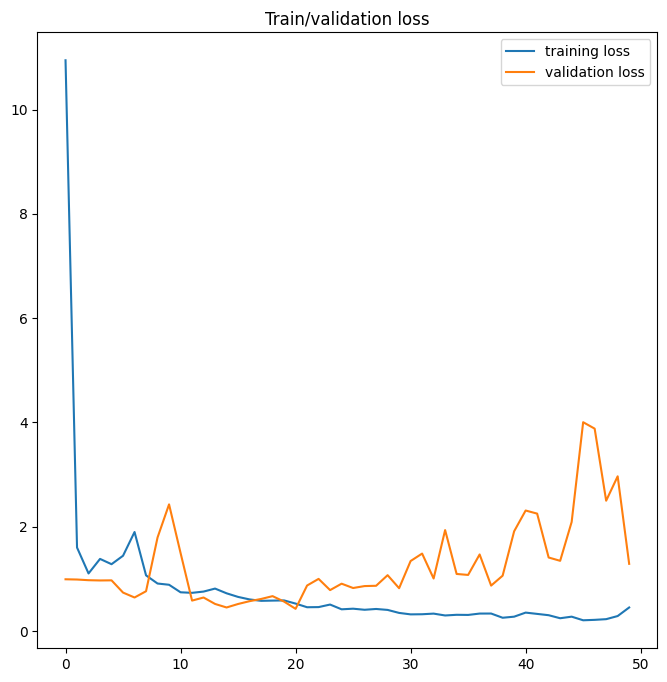

In [ ]:

 # Network training...
if train_flag == True:
        base_network = create_base_network(input_image_shape, embedding_size)

        input_images = Input(shape=input_image_shape, name='input_image') # input layer for images
        input_labels = Input(shape=(1,), name='input_label')    # input layer for labels
        embeddings = base_network([input_images])               # output of network -> embeddings
        labels_plus_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings

        # Defining a model with inputs (images, labels) and outputs (labels_plus_embeddings)
        model = Model(inputs=[input_images, input_labels],
                      outputs=labels_plus_embeddings)

        model.summary()
        plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

        # train session
        # opt = Adam(lr=0.0006)
        opt = Adam(learning_rate=0.0006)

        model.compile(loss=triplet_loss_adapted_from_tf,
                      optimizer=opt)

        # filepath = "semiH_trip_MNIST_v13_ep{epoch:02d}_BS%d.hdf5" % batch_size
        filepath = "semiH_trip_MNIST_v13_ep{epoch:02d}_BS%d.keras"
        # checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, period=65)
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        callbacks_list = [checkpoint]

        # Uses 'dummy' embeddings + dummy gt labels. Will be removed as soon as loaded, to free memory
        dummy_gt_train = np.zeros((len(x_train), embedding_size + 1))
        dummy_gt_val = np.zeros((len(x_val), embedding_size + 1))

        x_train = np.reshape(x_train, (len(x_train), x_train.shape[1], x_train.shape[1], 1))
        x_val = np.reshape(x_val, (len(x_val), x_train.shape[1], x_train.shape[1], 1))

        H = model.fit(
            x=[x_train,y_train],
            y=dummy_gt_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=([x_val, y_val], dummy_gt_val), callbacks=callbacks_list

           )

        plt.figure(figsize=(8,8))
        plt.plot(H.history['loss'], label='training loss')
        plt.plot(H.history['val_loss'], label='validation loss')
        plt.legend()
        plt.title('Train/validation loss')
        plt.show()
else:

        #####
        model = load_model('semiH_trip_MNIST_v13_ep25_BS256.hdf5',
                                        custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})

### Test the network

In [ ]:
# Test the network

# creating an empty network
testing_embeddings = create_base_network(input_image_shape,
                                          embedding_size=embedding_size)
x_embeddings_before_train = testing_embeddings.predict(np.reshape(X_test ,(len(X_test), 70, 70, 1)))
# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


### Visualizing the effect of embeddings

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


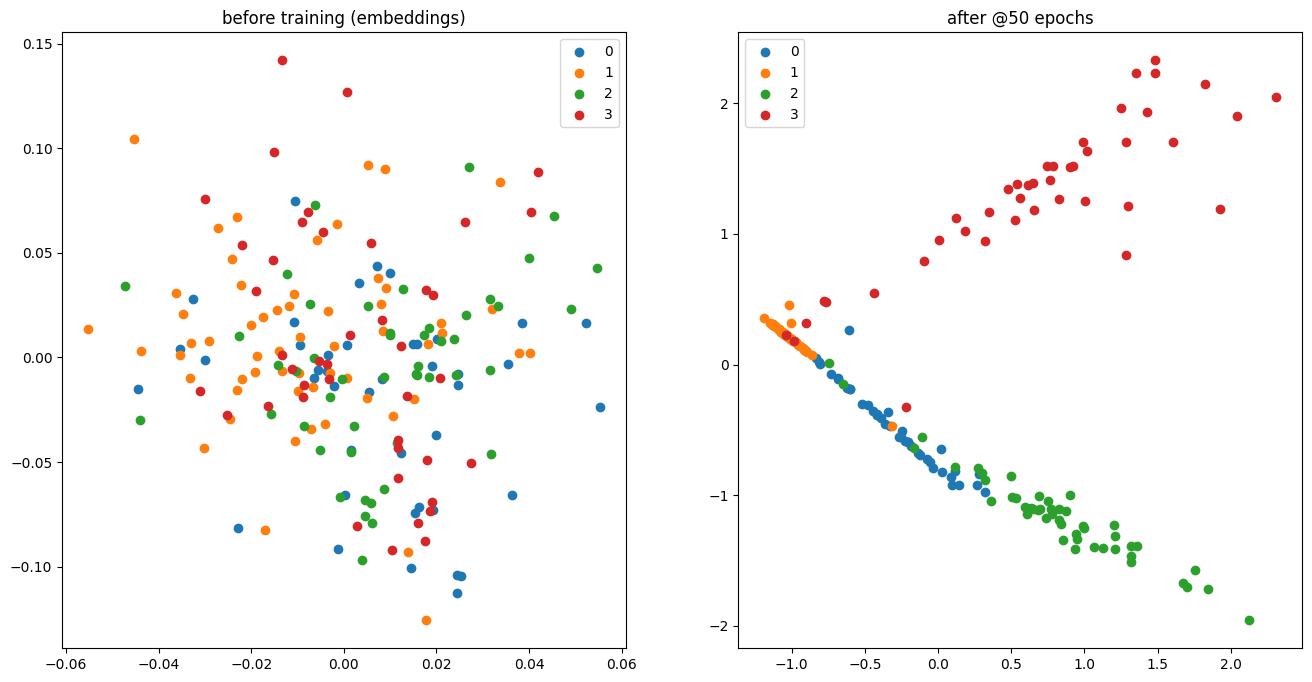

In [ ]:
# Visualizing the effect of embeddings -> using PCA!
from sklearn.preprocessing import StandardScaler

x_embeddings = testing_embeddings.predict(np.reshape(X_test, (len(X_test), 70, 70, 1)))
dict_embeddings = {}
dict_gray = {}
test_class_labels = np.unique(np.array(Y_test))

pca = PCA(n_components=no_of_components)
decomposed_embeddings = pca.fit_transform(x_embeddings)
# Normalize the output of PCA
scaler = StandardScaler()
decomposed_embeddings= scaler.fit_transform(decomposed_embeddings)
decomposed_gray = pca.fit_transform(x_embeddings_before_train)

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    decomposed_embeddings_class = decomposed_embeddings[Y_test == label]
    decomposed_gray_class = decomposed_gray[Y_test== label]

    plt.subplot(1,2,1)
    plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
    plt.title('before training (embeddings)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
    plt.title('after @%d epochs' % epochs)
    plt.legend()

plt.show()

In [ ]:
# Test the network

# creating an empty network
testing_embeddings = create_base_network(input_image_shape,
                                          embedding_size=embedding_size)
x_embeddings_before_train = testing_embeddings.predict(np.reshape(x_train ,(len(x_train), 70, 70, 1)))
# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights

457/457 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


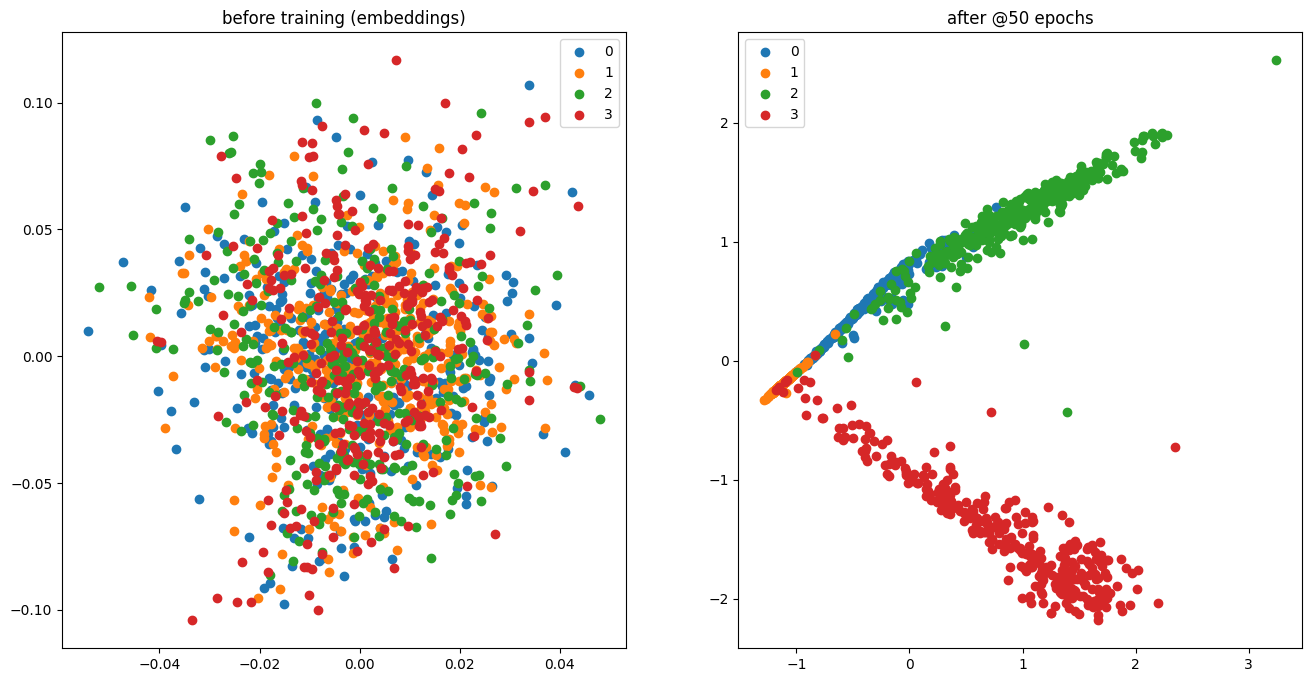

In [ ]:
# Visualizing the effect of embeddings -> using PCA!
from sklearn.preprocessing import StandardScaler

x_embeddings = testing_embeddings.predict(np.reshape(x_train, (len(x_train),70, 70, 1)))
dict_embeddings = {}
dict_gray = {}
test_class_labels = np.unique(np.array(y_train))

pca = PCA(n_components=no_of_components)
decomposed_embeddings = pca.fit_transform(x_embeddings)
# Normalize the output of PCA
scaler = StandardScaler()
decomposed_embeddings= scaler.fit_transform(decomposed_embeddings)
decomposed_gray = pca.fit_transform(x_embeddings_before_train)

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    decomposed_embeddings_class = decomposed_embeddings[y_train == label]
    decomposed_gray_class = decomposed_gray[y_train== label]

    plt.subplot(1,2,1)
    plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
    plt.title('before training (embeddings)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
    plt.title('after @%d epochs' % epochs)
    plt.legend()

plt.show()